<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

In [2]:
seaborn.__version__

'0.10.1'

Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [3]:
dataset = pandas.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

In [4]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [5]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [6]:
dataset[important_cols]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,-,10,10,10,10,10,9.29,7,8.18,6,8.73,4
1616,2008,DNK,Denmark,Western Europe,-,10,10,10,10,10,9.49,3,7.98,9,8.73,4
1617,2008,CHE,Switzerland,Western Europe,-,10,10,10,10,10,9.31,6,8.35,4,8.83,3
1618,2008,NZL,New Zealand,Oceania,-,10,10,10,10,10,9.42,4,8.46,3,8.94,2


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [7]:
dataset.dtypes

year                                  int64
ISO_code                             object
countries                            object
region                               object
hf_score                             object
                                      ...  
ef_regulation_business_compliance    object
ef_regulation_business               object
ef_regulation                        object
ef_score                             object
ef_rank                              object
Length: 120, dtype: object

In [8]:
dataset = dataset[important_cols].replace('-', numpy.nan)
for score_col in score_cols:
  dataset[score_col] = pandas.to_numeric(dataset[score_col])
dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


# Parte 1

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  3. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 
  2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.
  3. ¿Tiene sentido calcular la moda?
  4. ¿Cómo pueden sanearse los valores faltantes?
  5. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  
  

In [9]:
seaborn.set(font_scale=1.5)  # Para cambiar tamaño de labels en los gráficos

#### 1.1. Rango de las variables
Para las variables numéricas que son indicadores (excluimos el año), tomamos el valor máximo y el valor mínimo para cada una de ellas y luego calculamos la diferencia, que nos da el rango de cada variable.

In [10]:
print("Los rangos de las variables analizadas son:")
for score_col in score_cols:
    df_score_col = dataset[score_col]
    var_min = df_score_col.min()
    var_max = df_score_col.max()
    var_range = (var_max - var_min).round(4)
    print(f"'{score_col}': {var_range}")

Los rangos de las variables analizadas son:
'pf_identity_legal': 10.0
'pf_identity_sex_male': 10.0
'pf_identity_sex_female': 10.0
'pf_identity_sex': 10.0
'pf_identity_divorce': 10.0
'pf_identity': 10.0
'pf_score': 7.34
'pf_rank': 161.0
'ef_score': 6.53
'ef_rank': 161.0
'hf_score': 5.43
'hf_rank': 161.0


#### 1.2. Formas de comparar un país con otro
Entendemos que existen diversas formas de comparar dos países respecto a su desempeño en 'pf_identity' y 'hf_score':
1. Analizar gráficamente la evolución de cada país a lo largo de toda la serie temporal, para cada variable. Así podríamos identificar la tendencia de cada uno, así como comparar cómo se desempeñaba cada país al comienzo, durante y al final de la serie.
2. Calcular un estimador que pondere la media de cada país en toda la serie y la tendencia.
3. Analizar gráficamente la media móvil de cada país a lo largo de toda la serie temporal, para cada variable.
4. Tomar el valor puntual de cada variable en el último año para cada país.
5. Tomar la media de los últimos n años para cada país.

##### 1.2.1. Análisis gráfico de la evolución de las variables en el tiempo
<font color='red'>**TODO: DESCRIBIR LO QUE SE VE EN EL GRÁFICO**<font>

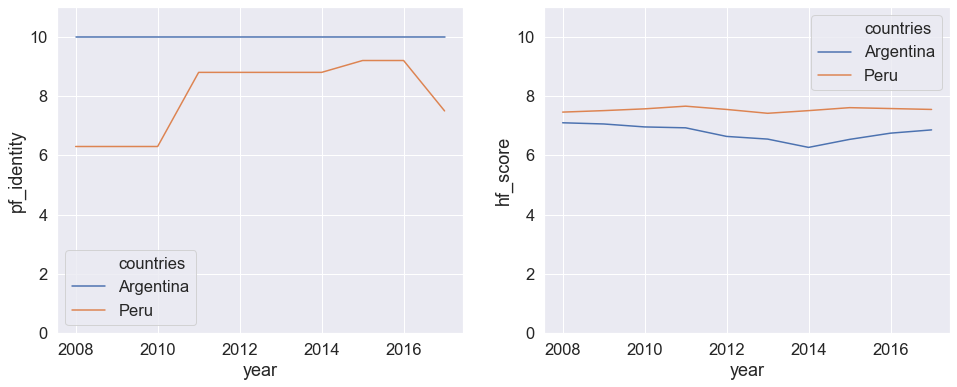

In [11]:
countries = ['Argentina', 'Peru']
sel_countries_filter = dataset['countries'].isin(countries)
df_sel_countries = dataset[sel_countries_filter]

fig, axs = plt.subplots(ncols=2, figsize=(16, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(data=df_sel_countries, x='year', y='pf_identity', hue='countries', ax=axs[0])
seaborn.lineplot(data=df_sel_countries, x='year', y='hf_score', hue='countries', ax=axs[1])
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10

In [12]:
Analizando la variable 'pf_identity' podemos ver que en la Argentina, sus habitantes se sienten libres en lo que respecta a su identidad.
Su valor se ha mantenido estable y en lo más alto en los últimos 10 años.
Interpretamos que Perú ha vivido una transición en el año 2010, lo que ha hecho que sus habitantes se sientan más libres. A partir del año 2016,
se puede ver nuevamente una tendencia a dismunuir la libertad de indentidad en este país, un retroceso para sus habitantes.
Sin embargo, en un análisis global 'hf_score' refleja que los habitantes de Perú viven más libres que los habitantes argentinos. Recordemos que
esta métrica tiene en cuenta otros factores más además de la libertad de identitdad de las personas, como por ejemplo el ámbito económico.
Por lo tanto, no es equivocado decir que Perú ha tenido una economía más estable en los últimos años que la Argentina, en la cual sus habitantes
se sienten más comodos.

SyntaxError: invalid syntax (<ipython-input-12-9f454e0a5613>, line 1)

##### 1.2.2. Estimador
<font color='red'>**TODO: CALCULAR**<font>

##### 1.2.3. Analizar gráficamente media móvil
<font color='red'>**TODO: DESCRIBIR LO QUE SE VE EN EL GRÁFICO**<font>

In [ ]:
df_sel_countries = df_sel_countries.sort_values(by=['countries', 'year'])  # ordeno para que la media móvil se calcule correctamente
df_sel_countries_rolling_mean = df_sel_countries.copy().groupby(['countries']).rolling(window=3, min_periods=1, on='year').mean()  # Media móvil por país tomando los últimos 3 años
df_sel_countries_rolling_mean = df_sel_countries_rolling_mean.reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(16, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(data=df_sel_countries_rolling_mean, x='year', y='pf_identity', hue='countries', ax=axs[0])
seaborn.lineplot(data=df_sel_countries_rolling_mean, x='year', y='hf_score', hue='countries', ax=axs[1])
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10

##### 1.2.4. Tomar valor puntual del último año
<font color='red'>**TODO: CALCULAR**<font>

##### 1.2.5. Tomar la media de los últimos n años
<font color='red'>**TODO: CALCULAR**<font>

#### 1.3 Cálculo de media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo. Comparación con la de Latinoamérica y el caribe
Realizamos el cálculo de las medidas estadísticas a continuación. A partir de ellos, concluimos que no tiene mucho sentido tomar una medida como la media, dado que al hacerlo de esa forma se pierde información sobre, por ejemplo, cómo viene evolucionando el indicador en el tiempo, además que valores extremos pueden estar distorsionando la media.

In [ ]:
selected_scores = ['pf_identity', 'hf_score']
la_filter = dataset['region'] == 'Latin America & the Caribbean'
dataset_la = dataset[la_filter]

for score in selected_scores:
    df_score_world = dataset[score]
    df_score_la = dataset_la[score]
    # Mean
    mean_world = df_score_world.mean()
    mean_la = df_score_la.mean()
    # Median
    median_world = df_score_world.median()
    median_la = df_score_la.median()
    # Standard deviation
    std_world = df_score_world.std()
    std_la = df_score_la.std()
    
    print(f"Respecto a la variable '{score}', los valores del mundo respecto a LA son:")
    print(f"Media del mundo: {mean_world.round(3)}; Media de LA: {mean_la.round(3)}")
    print(f"Mediana del mundo: {median_world.round(3)}; Mediana de LA: {median_la.round(3)}")
    print(f"Desviación estándar del mundo: {std_world.round(3)}; Desviación estándar de LA: {std_la.round(3)}\n")

#### 1.4 Cálculo de moda: ¿tiene sentido?
No tendría sentido tomar la moda debido a que tenemos pocos valores por cada país (máximo 10) y es probable que no haya moda dado que los indicadores son variables de tipo continuas, por lo que cada año puede haber valores distintos.

In [ ]:
for score in selected_scores:
    df_score_world = dataset[score]
    df_score_la = dataset_la[score]
    # Mode
    mode_world = df_score_world.mode()
    mode_la = df_score_la.mode()
    
    print(f"Respecto a la variable '{score}', los valores del mundo respecto a LA son:")
    print(f"Moda del mundo: {mode_world}; Media de LA: {mode_la}\n")


#### 1.5 ¿Cómo sanear los valores faltantes?
Una de las formas sería llenar los vacíos con la media del propio país o de la región o de países similares. También se podría tomar un promedio de años anteriores para interpolarlos.

In [ ]:
print("Cantidad de valores faltantes por columna:\n")
dataset.isna().sum()

In [13]:
def calculate_measure_by_column(df, col, agg='mean'):
    """
    Performs aggregation over col and fills NaN values of df with the result.
    """
    
    # Calculate measure by column
    df_by_col_and_year = df.copy()
    df_by_col_and_year = df_by_col_and_year.set_index([col, 'year'])[score_cols]
    df_measure_by_col = df_by_col_and_year.groupby([col]).agg(agg).reset_index()
    renamed_columns_dict = {col: col + '_measure' for col in score_cols}
    df_measure_by_col = df_measure_by_col.rename(columns=renamed_columns_dict)  # rename columns so that they are different than the ones in the original dataframe
    # Join measure to dataframe
    df_new = df.merge(df_measure_by_col, on=col, how='left')
    for score in score_cols:
        df_new[score] = numpy.where(df_new[score].isna(), df_new[score + '_measure'], df_new[score])
    df_new = df_new.drop(columns=renamed_columns_dict.values())
    return df_new

In [14]:
df_clean = calculate_measure_by_column(dataset, 'countries', agg='mean')

print("Cantidad de valores faltantes por columna luego de limpieza por país:\n")
df_clean.isnull().sum()

Cantidad de valores faltantes por columna luego de limpieza por país:



year                        0
ISO_code                    0
countries                   0
region                      0
pf_identity_legal         590
pf_identity_sex_male        0
pf_identity_sex_female      0
pf_identity_sex             0
pf_identity_divorce         0
pf_identity                 0
pf_score                    0
pf_rank                     0
ef_score                    0
ef_rank                     0
hf_score                    0
hf_rank                     0
dtype: int64

Como aún quedan valores vacíos, calculamos la media por región y se completamos los NaN restantes

In [15]:
df_clean = calculate_measure_by_column(df_clean, 'region', agg='mean')

print("Cantidad de valores faltantes por columna luego de limpieza por país y región:\n")
df_clean.isnull().sum()

Cantidad de valores faltantes por columna luego de limpieza por país y región:



year                      0
ISO_code                  0
countries                 0
region                    0
pf_identity_legal         0
pf_identity_sex_male      0
pf_identity_sex_female    0
pf_identity_sex           0
pf_identity_divorce       0
pf_identity               0
pf_score                  0
pf_rank                   0
ef_score                  0
ef_rank                   0
hf_score                  0
hf_rank                   0
dtype: int64


<font color='red'>**TODO: CALCULAR MEDIA DE ÚLTIMOS AÑOS Y RELLENAR CON ESO**<font>

#### 1.6. Outliers
Formas de detectarlos:
1. Gráficamente: realizando un boxplot por región, es posible distinguir, para cada región, algunas observaciones que se ubican fuera del intervalo de confianza definido en el boxplot (los puntos fuera del rango de los "bigotes"). También podría buscarse outliers dentro de una región por país.
2. Normalizando los valores por región, calculando la media y eligiendo una cantidad determinada de desviaciones estándar desde la media a partir de la cual consideramos que esos países son outliers.

##### 1.6.1. Detección de outliers de manera gráfica

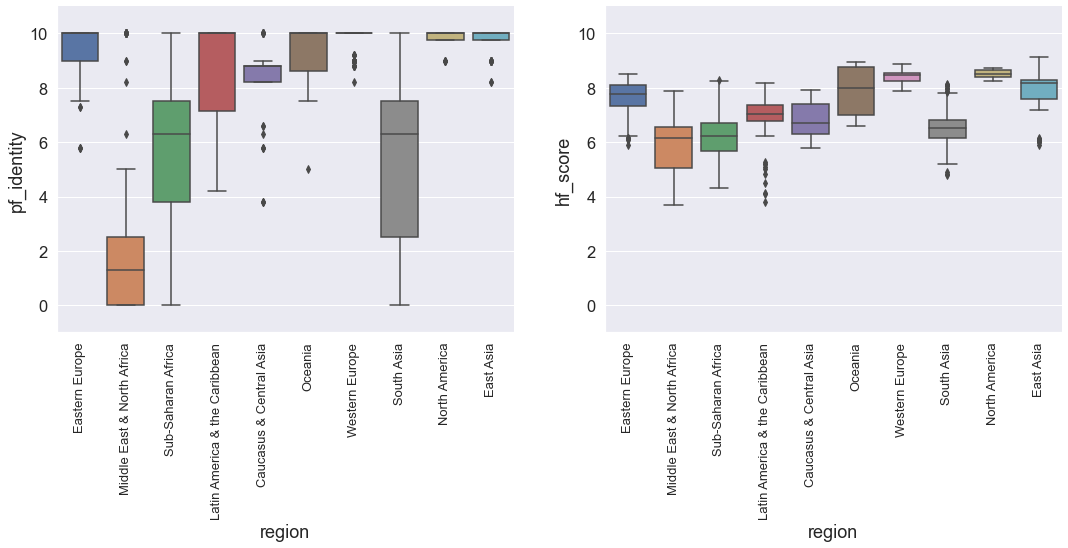

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
#plt.figure(figsize=(10,8))
seaborn.boxplot(x=df_clean['region'], y=df_clean['pf_identity'], ax=axs[0])
seaborn.boxplot(x=df_clean['region'], y=df_clean['hf_score'], ax=axs[1])
for ax in axs:
    ax.set_ylim(-1, 11)  # eje y no puede ser menor a 0 ni mayor a 10
    ax.tick_params(axis='x', labelrotation=90, labelsize=13)
seaborn.despine()

<font color='red'>**TODO: **<font>Encontramos outliers analizando por grupo (a nivel de región).
Si bien es posible encontrarlos gráficamente, también podríamos normalizar los datos
y establecer una determinada cantidad de desviaciones estándar a partir de la cual marcaríamos a los puntos que se desvían significativamente de la media.
COMPLETAR SI BORRAR OUTLIERS

## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?

Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

2.1

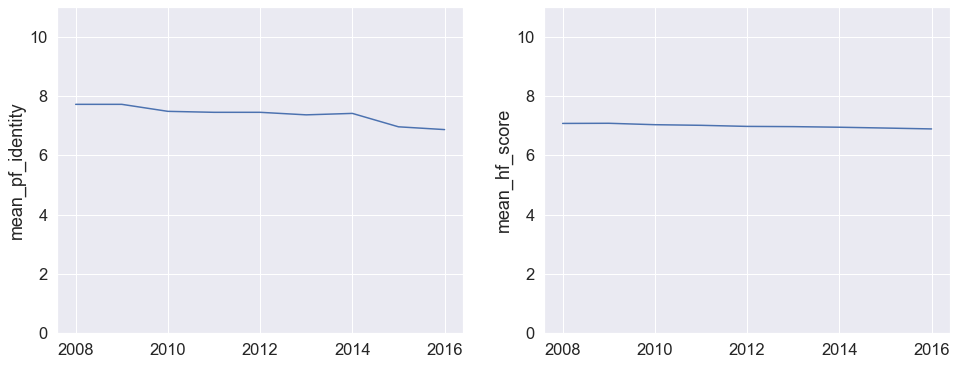

In [119]:
mean_pf_identity = []
mean_hf_score = []
years = []
min = dataset['year'].min()
max = dataset['year'].max()
selected_score = ['pf_identity', 'hf_score']
for year in range(min, max, 1):
    years.append(year)
    year_filter = dataset['year'] == year
    dataset_year = dataset[year_filter]
    values = dataset_year[selected_score]
    mean_pf_identity.append(values['pf_identity'].mean())
    mean_hf_score.append(values['hf_score'].mean())

df_pf_identity = pandas.DataFrame(mean_pf_identity, columns = ['mean_pf_identity'], index=years)
df_hf_score = pandas.DataFrame(mean_hf_score, columns = ['mean_hf_score'], index=years)

## GRAFICO

fig, axs = plt.subplots(ncols=2, figsize=(16, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(data=df_pf_identity, x=years, y='mean_pf_identity', ax=axs[0])
seaborn.lineplot(data=df_hf_score, x=years, y='mean_hf_score', ax=axs[1])
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10

Calcular media del mundo año a año

2.2

2.3

Elegir criterio para elegir países relevantes: mayor población?

## 3. Distribuciones
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos el conjunto de valores disponibles para esa region en estos gráficos?


## 4. Correlaciones y Relaciones

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.



In [ ]:
4.1

In [ ]:
4.2

In [ ]:
4.3

In [ ]:
4.4

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 
4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?